In [1]:
# Demo of paper: Women Wearing Lipstick: Measuring the Bias Between Object and Its Related Gender
# Note that the result may differ from the paper as we used distill models so it can run on the notebook.

In [2]:
%%capture --no-display
!pip install sentence_transformers

In [3]:
from lm_scorer.models.auto import AutoLMScorer as LMScorer
from sentence_transformers import SentenceTransformer, util

In [4]:
%%capture --no-display
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
device='cpu'
model = SentenceTransformer('stsb-distilbert-base',device=device)
batch_size = 1
scorer = LMScorer.from_pretrained('distilgpt2', device=device, batch_size=batch_size)

In [5]:
# from CLIP - Zero-Shot Prediction 
# CLIP # https://github.com/openai/CLIP 
visual_context_prob = 0.2183 
visual_context_label = 'motor scooter'

In [6]:
# image from testset 

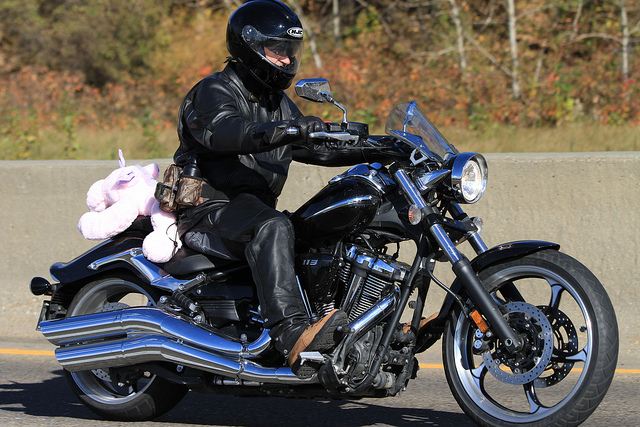

In [7]:
from IPython.display import Image
Image(filename="COCO_val2014_000000175024.jpg")

In [8]:
# Caption Baseline - Transformer 
#caption_man = 'a [MASK] riding a motorcycle on a road'
#caption_woman =  'a [MASK] riding a motorcycle on a road'
caption_man = 'a man riding a motorcycle on a road'
caption_woman =  'a woman riding a motorcycle on a road'

In [9]:
# language model (initial hypothesis)
LM_man  = scorer.sentence_score(caption_man, reduce="mean")
LM_woman  = scorer.sentence_score(caption_woman, reduce="mean")

In [10]:
def get_sim(x):
    x = cosine_scores = x.item()
    return x

In [11]:
# Cosine Distance Score - similarity 
caption_emb_man = model.encode(caption_man, convert_to_tensor=True)
caption_emb_woman = model.encode(caption_woman, convert_to_tensor=True)

visual_context_label_emb = model.encode(visual_context_label, convert_to_tensor=True)


cosine_scores_man = util.pytorch_cos_sim(caption_emb_man, visual_context_label_emb)
cosine_scores_woman = util.pytorch_cos_sim(caption_emb_woman, visual_context_label_emb)

cosine_scores_man = cosine_scores_man.cpu().numpy()
print('man_Cosine_Distance', get_sim(cosine_scores_man))

cosine_scores_woman = cosine_scores_woman.cpu().numpy()
print('woman_Cosine_Distance', get_sim(cosine_scores_woman))

man_Cosine_Distance 0.22913998365402222
woman_Cosine_Distance 0.18058109283447266


In [12]:
# Gender Score Estimation 

In [13]:
class Gender_Bias_Score:
  def __init__(self, LM, visual_context_prob, sim):
    self.LM = LM
    self.visual_context_prob = visual_context_prob
    self.sim = sim

  def belief_revision(self):
    score = pow(float(LM), pow((1 - float(sim)) / (1 + float(sim)), 1 - float(visual_context_prob)))
    return score

In [14]:
# man Gender Score
sim = 0.22913998 # cosine_distance_scores_man
LM = 0.09609337896108627 #  # initial bias (LM_man) 
score_man =  Gender_Bias_Score(LM, visual_context_prob,sim)
score_m = score_man.belief_revision()
print ('man-motorcycle',score_m)

man-motorcycle 0.19660117661766371


In [15]:
# woman Gender Score 
sim = 0.1805811 # cosine_distance_scores_woman
LM = 0.09790597856044769 # initial bias (LM_woman) 
score_woman =  Gender_Bias_Score(LM, visual_context_prob, sim)
score_w = score_woman.belief_revision()
print ('woman-motorcycle',score_w)

woman-motorcycle 0.17434767121739933


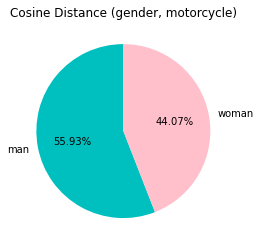

In [16]:
# Plot Cosine Distance similarity gender bias ratio (gender, motorcycle) 
import matplotlib.pyplot as plt

labels = 'man', 'woman'
sections = [get_sim(cosine_scores_man), get_sim(cosine_scores_woman)]
colors = ['c', 'pink']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.title('Cosine Distance (gender, motorcycle)')
plt.show()

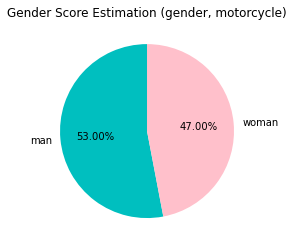

In [17]:
# Plot Gender Score Estimation gender bias ratio (gender, motorcycle) 
import matplotlib.pyplot as plt
labels = 'man', 'woman'


sections = [score_m, score_w]

colors = ['c', 'pink']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.title('Gender Score Estimation (gender, motorcycle)')
plt.show()